In [1]:
%matplotlib notebook
%load_ext snakeviz
%load_ext autoreload
%autoreload 2
from supplementary.simple_choice_model import hits_gen as hits
from supplementary.simple_choice_model import sim_tools
import ipywidgets as wid

import loc_utils as lut
import numpy as np
import pandas as pd
import scipy as sp
import contextlib
import matplotlib.pyplot as plt
from IPython.display import display
colors = ['#43799d', '#cc5b46', '#ffbb00', '#71bc78', '#43799d', '#cc5b46', '#ffbb00', '#71bc78']

@contextlib.contextmanager
def temp_seed(seed):
    state = np.random.get_state()
    np.random.seed(seed)
    try:
        yield
    finally:
        np.random.set_state(state)

## Estimating population parameters from individual-level data (via negative log of trial-wise composite likelihood)
### TODO: 
- Estimate parameters
- Compare data generated by estimated parameters to real data (histograms of averaged selection)
- Visualize ^

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


loss    alpha     beta      tau
grp ntm                                     
0   1   264.67664  2.32710 -0.69592 10.36418
    2   302.86657  2.33972 -0.16941  1.78240
    3   313.77016  0.56591  1.13344 10.43096
1   1   229.01108  0.03385 -0.66616  3.47007
    2   292.44895  0.64736 -2.40178 10.78755
    3   304.30391 -0.81200 -1.17034 11.67739

<IPython.core.display.Javascript object>


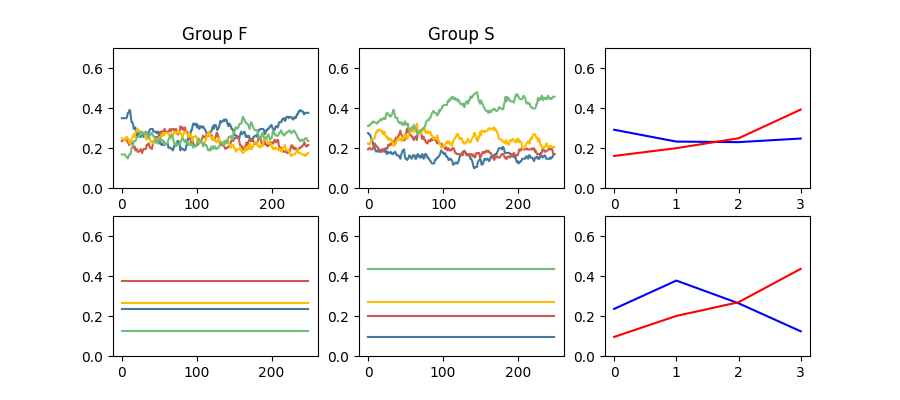

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [18]:
def neg_log_likelihood_no_inertia(params, *args):
    alpha, beta, tau = params
    LP, PC, choices = args
    U = alpha*LP + beta*PC
    P = (np.exp(U * tau).T / np.sum(np.exp(U * tau), axis=1)).T
    logP = np.log(P[choices.astype(bool)])
    logL = np.sum(logP, axis=0)
    return -logL

def neg_log_likelihood_without_tau(params, *args):
    a, b, c = params
    LP, PC, I, choices = args
    U = a*LP + b*PC + c*I
    P = (np.exp(U * 1).T / np.sum(np.exp(U * 1), axis=1)).T
    logP = np.log(P[choices.astype(bool)])
    logL = np.sum(logP, axis=0)
    return -logL

def neg_log_likelihood_with_tau(params, *args):
    a, b, c, t = params
    LP, PC, I, choices = args
    U = a*LP + b*PC + c*I
    P = (np.exp(U * t).T / np.sum(np.exp(U * t), axis=1)).T
    logP = np.log(P[choices.astype(bool)])
    logL = np.sum(logP, axis=0)
    return -logL

# Estimate the params
df = lut.unpickle('supplementary/simple_choice_model/data/fit_data.pkl')
df = df.loc[df.ntm != 0, :]
data_dict = {'sid': [], 'grp': [], 'ntm': [], 'loss': [], 'alpha': [], 'beta': [], 'gamma': [], 'tau': []}
alpha_bounds = [-10, 10]
beta_bounds = [-10, 10]
gamma_bounds = [-10, 10]
tau_bounds = [0, 100]

bounds = (alpha_bounds, beta_bounds, tau_bounds)
boudns = ()

for i, sdf in df.groupby('sid'):
    sid, grp, ntm = sdf.sid.values[0], sdf.grp.values[0], sdf.ntm.values[0]
    lps = sdf.loc[:, 'lp1':'lp4'].values[1:, :]
    pcs = sdf.loc[:, 'pc1':'pc4'].values[1:, :]
#     ins = sdf.loc[:, 'in1':'in4'].values[1:, :]
    chs = sdf.loc[:, 'ch1':'ch4'].values[1:, :]

    data = (lps, pcs, chs)
    init_guess = sim_tools.rand_params(bounds)
    opt_res = sp.optimize.minimize(fun=neg_log_likelihood_no_inertia, x0=init_guess, args=data,
                                   method=None, bounds=bounds,
                                   jac=None, hess=None, hessp=None, 
                                   constraints=(), tol=None, callback=None, options=None)
# Store params   
    data_dict['sid'].append(sid)
    data_dict['grp'].append(grp)
    data_dict['ntm'].append(ntm)
    data_dict['loss'].append(opt_res.fun)
    data_dict['alpha'].append(opt_res.x[0])
    data_dict['beta'].append(opt_res.x[1])
#     data_dict['gamma'].append(opt_res.x[2])
    data_dict['tau'].append(opt_res.x[2])
data_dict.pop('gamma')

# Calculate parameter stats
fdf = pd.DataFrame(data_dict)
gfdf = fdf.groupby(['grp','ntm']).mean().drop(columns=['sid'])
display(gfdf)

# Visualize empirical data
fig = plt.figure('Fitting individuals', figsize=[9,4])
group_choices = df.groupby(['grp', 'trial']).mean()
for grp in [0, 1]:
    ax = fig.add_subplot(2,3,grp+1)
    ax.set_title('Group {}'.format('FS'[grp]))
    ax.set_ylim(0,.7)
    for tid in [1, 2, 3, 4]:   
        ax.plot(group_choices.loc[(grp, slice(None)), 'ch{}'.format(tid)].values, color = colors[tid-1])
    ax = fig.add_subplot(2,3,3)
    ax.plot(group_choices.loc[(grp, slice(None)), 'ch1':'ch4'].values.mean(axis=0), color='br'[grp])       
    ax.set_ylim(0,.7)
    
# Visualize data generated by simulation with estimated parameters
df = lut.unpickle('supplementary/simple_choice_model/data/fit_data.pkl')
df = df.loc[df.ntm != 0, :]
# N_sim = 100
N_trials = 250

for grp in [0, 1]:
    sids = df.loc[(df.grp==grp), 'sid'].unique()
    N_sim = sids.size
    sids = np.random.choice(sids, size=N_sim)
    hits_params = hits.get_parametric(grp=grp)
    trials = np.arange(N_trials) + 1
    probs = np.stack([1 / (1 + np.exp(-(hits_params[tid][0] + hits_params[tid][1]*trials))) for tid in [1,2,3,4]], axis=1)
    simhits = (np.random.rand(N_sim, N_trials, 4) <= probs).astype(int)
    init_data = sim_tools.get_multiple_sids(sids)

    alpha, beta, tau = fdf.groupby(['grp']).mean().loc[grp, 'alpha':'tau'].values
    simdata = []
    for i, sid in enumerate(sids):
        runs = []
        for s in range(50):
            choices = sim_tools.simple_simulation(init_state=init_data[i, :, :], 
                                              win1=10, win2=9, N=250, 
                                              hits = simhits[i, :, :], 
                                              alpha=alpha, beta=beta, 
                                              gamma=gamma, tau=tau)
            runs.append(np.eye(4)[choices.astype(int)])
        simdata.append(np.stack(runs, axis=0).mean(axis=0))
    simdata = np.stack(simdata, axis=0).mean(axis=0)
    
    ax = fig.add_subplot(2,3,grp+4)
    ax.set_ylim(0,.7)
    for tid in [1, 2, 3, 4]:   
        ax.plot(simdata[:, tid-1], color = colors[tid-1])
    ax = fig.add_subplot(2,3,6)
    ax.plot(simdata.mean(axis=0), color='br'[grp])
    ax.set_ylim(0,.7)

## Estimating parameters from group-level data (via KL divergence)

### TODO:
- Make sure the D_KL loss is computed appropriately (test on various vector pairs)
- Try an exhaustive grid search of the sample space to see which regions correspond to minimal losses
    - See if these "good" parameter space regions make sense
- Build an interactive visualization (alpha and beta on the x, y axis, with grids colored according to loss value). TAU should be represented as a slider that should change the appearence of the 2d-alpha-beta grid.
    - Try to visualize the data-simulation comparison histograms by selecting data by click_on event on the imshow object.

In [ ]:
# %%snakeviz
def DKL_loss(params, *args):
    a, b, t = params
    sids, data_beg, data_mid, data_end, init_data, simhits = args
    
    choices_beg = []
    choices_mid = []
    choices_end = []
    for i, sid in enumerate(sids):
        choices = sim_tools.simple_simulation(init_state=init_data[i, :, :], 
                                              win1=10, win2=9, N=250, 
                                              hits = simhits[i, :, :], 
                                              alpha=a, beta=b, 
                                              gamma=0, tau=t)
        choices_beg.append(np.eye(4)[choices[:10].astype(int)])
        choices_mid.append(np.eye(4)[choices[:250//2].astype(int)])
        choices_end.append(np.eye(4)[choices.astype(int)])
    choices_beg = np.stack(choices_beg).mean(axis=0).mean(axis=0)
    choices_mid = np.stack(choices_mid).mean(axis=0).mean(axis=0)
    choices_end = np.stack(choices_end).mean(axis=0).mean(axis=0)
    DKL_beg = sp.special.kl_div(data_beg, choices_beg).sum()
    DKL_mid = sp.special.kl_div(data_mid, choices_mid).sum()
    DKL_end = sp.special.kl_div(data_end, choices_end).sum()
    
    loss = DKL_beg + DKL_mid + DKL_end
    return loss


df = lut.unpickle('supplementary/simple_choice_model/data/fit_data.pkl')
df = df.loc[df.ntm != 0, :]
data_dict = {'grp': [], 'ntm': [], 'loss': [], 'alpha': [], 'beta': [], 'gamma': [], 'tau': []}
N_sim = 50
N_trials = 250
bounds = ([-1,1],[-1,1],[0,50])

grp, ntm = 0, 3
sids = df.loc[(df.grp==grp), 'sid'].unique()
print('Estimating params for GRP-{}, NTM-{} ({}/{}) ...'.format(grp, ntm, N_sim, sids.size))
sids = np.random.choice(sids, size=N_sim)

data_beg = df.loc[(df.grp==grp) & (df.ntm==ntm) & (df.trial<=10), 'ch1':'ch4'].values.mean(axis=0)
data_mid = df.loc[(df.grp==grp) & (df.ntm==ntm) & (df.trial<=249//2), 'ch1':'ch4'].values.mean(axis=0)
data_end = df.loc[(df.grp==grp) & (df.ntm==ntm) & (df.trial>=1), 'ch1':'ch4'].values.mean(axis=0)

hits_params = hits.get_parametric(grp=grp)
trials = np.arange(N_trials) + 1
probs = np.stack([1 / (1 + np.exp(-(hits_params[tid][0] + hits_params[tid][1]*trials))) for tid in [1,2,3,4]], axis=1)
simhits = (np.random.rand(N_sim, N_trials, 4) <= probs).astype(int)
init_data = sim_tools.get_multiple_sids(sids)
data = (sids, data_beg, data_mid, data_end, init_data, simhits)

# params = (0.14954,-0.11199,0.47016,11.34070)
# params = (0.10445,-0.21977,0.47538,10.04687)
init_guess = sim_tools.rand_params(bounds)
# init_guess = gfdf.loc[(grp, ntm),'alpha':'tau'].values
# DKL_loss(params, *data)

opt_res = sp.optimize.minimize(fun=DKL_loss, 
                               x0=init_guess,
                               args=data,
                               bounds=bounds)
print(init_guess)
print(opt_res.x)
# for grp in [0, 1]:
#     for ntm in [1, 2, 3]: 
#         data_dict['grp'].append(grp)
#         data_dict['ntm'].append(ntm)
#         data_dict['loss'].append(opt_res.fun)
#         data_dict['alpha'].append(opt_res.x[0])
#         data_dict['beta'].append(opt_res.x[1])
#         data_dict['gamma'].append(opt_res.x[2])
#         data_dict['tau'].append(opt_res.x[3])

In [ ]:
def DKL_loss(params, *args):
    a, b, t = params
    sids, data_beg, data_mid, data_end, init_data, simhits = args
    
    choices_beg = []
    choices_mid = []
    choices_end = []
    for i, sid in enumerate(sids):
        choices = sim_tools.simple_simulation(init_state=init_data[i, :, :], 
                                              win1=10, win2=9, N=250, 
                                              hits = simhits[i, :, :], 
                                              alpha=a, beta=b, 
                                              gamma=0, tau=t)
        choices_beg.append(np.eye(4)[choices[:10].astype(int)])
        choices_mid.append(np.eye(4)[choices[:250//2].astype(int)])
        choices_end.append(np.eye(4)[choices.astype(int)])
    choices_beg = np.stack(choices_beg).mean(axis=0).mean(axis=0)
    choices_mid = np.stack(choices_mid).mean(axis=0).mean(axis=0)
    choices_end = np.stack(choices_end).mean(axis=0).mean(axis=0)
    DKL_beg = sp.special.kl_div(data_beg, choices_beg).sum()
    DKL_mid = sp.special.kl_div(data_mid, choices_mid).sum()
    DKL_end = sp.special.kl_div(data_end, choices_end).sum()
#     print(data_beg)
#     print(choices_beg)
#     print(data_mid)
#     print(choices_mid)
#     print(data_end)
#     print(choices_end)
    loss = DKL_beg + DKL_mid + DKL_end
    return loss, [data_beg, data_mid, data_end], [choices_beg, choices_mid, choices_end]


loss, _data, preds = DKL_loss(opt_res.x, *data)

plt.figure('new', figsize=[9, 3])
for i in range(3):
    plt.subplot(131+i)
    plt.plot([1,2,3,4], _data[i], c='k', ls='-')
    plt.plot([1,2,3,4], preds[i], c='k', ls='--')
    plt.ylim(0,.6)

In [ ]:
# def neg_log_likelihood(params, *args):
#     a, b, c, t = params
#     LP, PC, I, choices = args
#     U = a*LP + b*PC + c*I
#     P = (np.exp(U * t).T / np.sum(np.exp(U * t), axis=1)).T
#     logP = np.log(P[choices.astype(bool)])
#     logL = np.sum(logP, axis=0)
#     return -logL

def neg_log_likelihood(params, *args):
    a, b, c = params
    LP, PC, I, choices = args
    U = a*LP + b*PC + c*I
    P = (np.exp(U * 1).T / np.sum(np.exp(U * 1), axis=1)).T
    logP = np.log(P[choices.astype(bool)])
    logL = np.sum(logP, axis=0)
    return -logL

df = lut.unpickle('supplementary/simple_choice_model/data/fit_data.pkl')
sdf = df.loc[df.sid == 6, :]


sid, grp, ntm = sdf.sid.values[0], sdf.grp.values[0], sdf.ntm.values[0]
lps = sdf.loc[:, 'lp1':'lp4'].values[1:, :]
pcs = sdf.loc[:, 'pc1':'pc4'].values[1:, :]
ins = sdf.loc[:, 'in1':'in4'].values[1:, :]
chs = sdf.loc[:, 'ch1':'ch4'].values[1:, :]

data = (lps, pcs, ins, chs)

ress = []
init_guess = np.random.rand(3)
print(neg_log_likelihood(init_guess, *data))
for i in range(100):
    opt_res = sp.optimize.minimize(fun=neg_log_likelihood, x0=init_guess, args=data,
                                   method=None,
                                   jac=None, hess=None, hessp=None, 
                                   constraints=(), tol=None, callback=None, options=None)
    ress.append(opt_res.x)
m = np.stack(ress,axis=0).mean(axis=0)
print(m)
print(neg_log_likelihood(m, *data))